# Notebook 2: Daymet data access
Waterhackweek 2020 | Steven Pestana (spestana@uw.edu)

**By the end of this notebook you will be able to:**
* Access DayMet with xarray, describe its data structure and components
* Select subsets of DayMet in time and space
* Plot DayMet maps and time series with xarray

---


## What is Daymet?


<div align="left" style="display:inline-block;float:left;width:50%;">

Daymet is a dataset of gridded daily weather data at 1 km resolution for continental North America, Hawaii, and Puerto Rico and is produced from a combination of daily meteorlogical observations and computer models to interpolate/extrapolate those observations. ([Read more about how Daymet is produced here](https://daymet.ornl.gov/overview))
 
    
The data products produced by the Daymet algorithms are available at the [Oak Ridge National Lab DAAC](https://daymet.ornl.gov/) as NetCDF files in the Lambert Conformal Conic projection system.   
    
Also check out [this recent article about Daymet](https://earthdata.nasa.gov/learn/articles/daymet-and-daymet-2019-data) for more information.

    
### How can we access this data? 
 * [ORNL DAAC web portal](https://daymet.ornl.gov/getdata)
 * [ulmo](https://ulmo.readthedocs.io/en/latest/api.html?highlight=daymet#module-ulmo.nasa.daymet) *(DAYMET single pixel timeseries)*
 * [daymetpy](bluegreen-labs.github.io/daymetpy) *([NetCDF Subset and Single Pixel Extraction web service](https://daymet.ornl.gov/web_services.html))*
 * [OPeNDAP](https://en.wikipedia.org/wiki/OPeNDAP) Application Programming Interface (API)

</div>


<div align="right" style="display:inline-block;float:right;width:50%;">

<img src="https://daymet.ornl.gov/static/graphics/homepage_map.png" width=300>

</div>


We will be using the [**OPeNDAP**](https://en.wikipedia.org/wiki/OPeNDAP) (Open-source Project for a Network Data Access Protocol) endpoint and **xarray** to access the "*Daily Surface Weather Data on a 1-km Grid for North America, Version 3*" data product
* [THREDDS Data Server catalog page for this product](https://thredds.daac.ornl.gov/thredds-daymet/catalog/daymet-v3-agg/catalog.html?dataset=daymet-v3-agg/na.ncml)
  * OPeNDAP endpoint url: `https://thredds.daac.ornl.gov/thredds-daymet/dodsC/daymet-v3-agg/na.ncml` (xarray can directly read from this url)

---

**To get started, import xarray and other libraries we'll be using in this notebook...**

In [1]:
import xarray as xr

# for working with geospatial data
import geopandas as gpd
from pyproj import CRS
from shapely import geometry

# for plotting, import matplotlib.pyplot
import matplotlib.pyplot as plt
# tell jupyter to display plots "inline" in the notebook
%matplotlib inline

**Use xarray to open the dataset at this OPeNDAP endpoint**


In [2]:
ds = xr.open_dataset( "https://thredds.daac.ornl.gov/thredds-daymet/dodsC/daymet-v3-agg/na.ncml" )

**What did we just open with xarray? Look at the dataset's structure and metadata:**

* *Dimensions* of **time**, **x**, and **y**
* *Coordinates* of **time**, **x**, **y**, **lat**, and **lon**
* *Data variables*
* *Attributes*



In [3]:
ds

<xarray.Dataset>
Dimensions:                  (nv: 2, time: 14600, x: 7814, y: 8075)
Coordinates:
  * x                        (x) float32 -4560250.0 -4559250.0 ... 3252750.0
  * y                        (y) float32 4984000.0 4983000.0 ... -3090000.0
  * time                     (time) datetime64[ns] 1980-01-01 ... 2019-12-31
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
Dimensions without coordinates: nv
Data variables:
    lambert_conformal_conic  int16 ...
    yearday                  (time) int16 ...
    time_bnds                (time, nv) datetime64[ns] ...
    dayl                     (time, y, x) float32 ...
    prcp                     (time, y, x) float32 ...
    srad                     (time, y, x) float32 ...
    swe                      (time, y, x) float32 ...
    tmax                     (time, y, x) float32 ...
    tmin                     (time, y, x) float32 ...
    vp                       (time, y, x) float32 ...
Attributes:
    start_year:        1980
    source:            Daymet Software Version 3.0
    Version_software:  Daymet Software Version 3.0
    Version_data:      Daymet Data Version 3.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    title:             Daymet: Daily Surface Weather Data on a 1-km Grid for ...
    institution:       Oak Ridge National Laboratory Distributed Active Archi...
    end_year:          2019

Reference figure for xarray data structure components:

<img src="https://xarray.pydata.org/en/stable/_images/dataset-diagram.png" width=700>

**Look at a single data variable and its metadata:**

In [4]:
ds.prcp

<xarray.DataArray 'prcp' (time: 14600, y: 8075, x: 7814)>
[921231530000 values with dtype=float32]
Coordinates:
  * x        (x) float32 -4560250.0 -4559250.0 ... 3251750.0 3252750.0
  * y        (y) float32 4984000.0 4983000.0 4982000.0 ... -3089000.0 -3090000.0
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2019-12-31
    lat      (y, x) float32 ...
    lon      (y, x) float32 ...
Attributes:
    long_name:     daily total precipitation
    units:         mm/day
    grid_mapping:  lambert_conformal_conic
    cell_methods:  area: mean time: sum

**What coordinate reference system does DayMet use?**

In [5]:
ds.lambert_conformal_conic.attrs

{'grid_mapping_name': 'lambert_conformal_conic',
 'longitude_of_central_meridian': -100.0,
 'latitude_of_projection_origin': 42.5,
 'false_easting': 0.0,
 'false_northing': 0.0,
 'standard_parallel': array([25., 60.]),
 'semi_major_axis': 6378137.0,
 'inverse_flattening': 298.257223563,
 'longitude_of_prime_meridian': 0.0}

This gives us all the information we need to define the coordinate ystem, and therefore transform other coordinates into or out of this coordinate space.

(Note that the `semi_major_axis`, `inverse_flattening`, and `longitude_of_prime_meridian` correspond to the [WGS84 Ellipsoid](https://en.wikipedia.org/wiki/World_Geodetic_System#WGS84).)


**We now know what the data structure is and what the metadata tells us!**

---
**Now we are going to subset the DayMet data to a smaller area to work with.** This Dataset contains a lot of information, which will take a long time to load if we tried to look at everything at once.

Let's start by selecting a region around Washington state.

Remember that we have these options for [indexing or slicing](https://xarray.pydata.org/en/stable/indexing.html) xarray DataArrays and Datasets:

| Dimension lookup | Index lookup | DataArray syntax | Dataset syntax |
| ---              | ---          | ---              | ---            |
| positional       | by integer   | `da[:,0]`        | *n/a* |
| positional       | by label     | `da.loc[:,'east_watershed']` | *n/a* |
| by name          | by integer   | `da.isel(watershed=0)` | `ds.isel(location=0)` |
| by name          | by label     | `da.sel(watershed='east_watershed')` | `ds.sel(location='stream_gage_1')` |


What we'll do is find the Latitude and Longitude bounds approximately around Washington state, then use `.sel()` method with a `slice` in the **x** and **y** dimensions.

**To start, we can define a bounding box in Longitude and Latitude coordinates** using [geopandas](https://geopandas.org/) and [shapely](https://shapely.readthedocs.io/en/latest/manual.html).

In [6]:
# Specify the region we want to look at with DayMet (lon_min, lat_min, lon_max, lat_max)
# and the coordinate system we are providing the bounding box coordinates in (epsg:4326)

bounding_box = gpd.GeoSeries(geometry.box(-125.0, 45.5, -117.0, 49.0), 
                             crs='epsg:4326')

**Next, we need to transform these coordinates from EPSG:4326 into the Lambert Conformal Conic coordinate system used by DayMet.** 

Here we will use [pyproj](https://pyproj4.github.io/pyproj/stable/) to read DayMet's coordinate reference system and convert it into a format we can use.

In [7]:
# Get the coordinate reference system used by DayMet
daymet_crs = CRS.from_cf(ds.lambert_conformal_conic.attrs)

In [8]:
# Reproject our bounding box polygon into this new coordinate system (Lambert Conformal Conic)
bounding_box = bounding_box.to_crs(daymet_crs)

In [9]:
# Take a look at our bounding box object
bounding_box

0    POLYGON ((-1258946.566 446607.700, -1183671.05...
dtype: geometry

In [10]:
# Now we can get our bounds out in Daymet's coordinate system using
bounding_box.bounds

# These can be accessed indiviudally as for example:
# bounding_box.bounds.minx[0]
# where [0] cooresponds to our first and only row

,minx,miny,maxx,maxy
0,-1.836486e+06,446607.699546,-1.183671e+06,950503.83288


**Now use the bounds to slice the DayMet dataset in the x and y dimensions to select the Washington area.**

In [11]:
# Select this region from our DayMet Dataset
washington = ds.sel(x = slice(bounding_box.bounds.minx[0], bounding_box.bounds.maxx[0]), # Here we are slicing the x axis with slice(minx, maxx)
                   y = slice(bounding_box.bounds.maxy[0], bounding_box.bounds.miny[0])) # Note that we are slicing the *inverted* y axis with slice(maxy,miny)

# Look at what we selected from DayMet
washington

<xarray.Dataset>
Dimensions:                  (nv: 2, time: 14600, x: 653, y: 504)
Coordinates:
  * x                        (x) float32 -1836250.0 -1835250.0 ... -1184250.0
  * y                        (y) float32 950000.0 949000.0 ... 448000.0 447000.0
  * time                     (time) datetime64[ns] 1980-01-01 ... 2019-12-31
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
Dimensions without coordinates: nv
Data variables:
    lambert_conformal_conic  int16 -32767
    yearday                  (time) int16 0 1 2 3 4 5 ... 360 361 362 363 364
    time_bnds                (time, nv) datetime64[ns] 1980-01-01 ... 2020-01-01
    dayl                     (time, y, x) float32 ...
    prcp                     (time, y, x) float32 ...
    srad                     (time, y, x) float32 ...
    swe                      (time, y, x) float32 ...
    tmax                     (time, y, x) float32 ...
    tmin                     (time, y, x) float32 ...
    vp                       (time, y, x) float32 ...
Attributes:
    start_year:        1980
    source:            Daymet Software Version 3.0
    Version_software:  Daymet Software Version 3.0
    Version_data:      Daymet Data Version 3.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    title:             Daymet: Daily Surface Weather Data on a 1-km Grid for ...
    institution:       Oak Ridge National Laboratory Distributed Active Archi...
    end_year:          2019

**What does this look like now?** Plot tmax for the first day using `.isel()` on the DataArray:

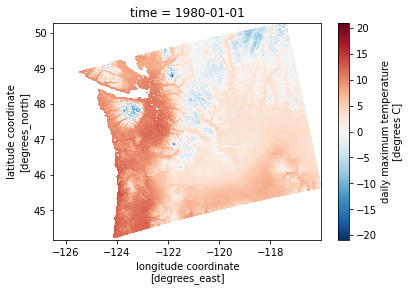

In [12]:
washington.tmax.isel(time=0).plot(x='lon', y='lat')

# Note that this is equivalent to:
# washington.tmax[0].plot(x='lon', y='lat')

---

**We can also try selecting in time and space dimensions.** 

Here let's look at snow water equivalent (SWE) for a single water year (October 2016 - September 2017) for a point near Mt. Rainier.

In [13]:
# Define a point with Longitude and Latitude (EPSG:4326)
my_point_lon_lat = gpd.GeoSeries(geometry.Point(-121.6, 46.9),
                                 crs='epsg:4326')

# Convert to the DayMet coordinate reference system as we did previously with our bounding box
my_point = my_point_lon_lat.to_crs(daymet_crs)

**xarray allows us to stack multiple methods in a single expression.** 

Here we have two `.sel()` methods applied to the `ds.swe` DataArray. The first selects a time slice, the second selects x and y coordinates for our point.

Using `method='nearest'` means that it'll find the x and y coordinates nearest to what we provide with `my_point.x` and `my_point.y`

In [14]:
# Select from DayMet SWE a time slice and an x and y point using the 'nearest' method
my_point_swe = washington.swe.sel(time=slice('10-2016','9-2017')).sel(x=my_point.x[0], y=my_point.y[0], method='nearest')

# we separate our time and space selections because we need to use method='nearest' with x and y,
# and that method does not work with slice objects like we used in the time dimension

In [15]:
# Look at the result
my_point_swe

<xarray.DataArray 'swe' (time: 364)>
array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)
Coordinates:
    x        float32 -1554250.0
    y        float32 669000.0
  * time     (time) datetime64[ns] 2016-10-01 2016-10-02 ... 2017-09-30
    lat      float32 ...
    lon      float32 ...
Attributes:
    long_name:     snow water equivalent
    units:         kg/m2
    grid_mapping:  lambert_conformal_conic
    cell_methods:  area: mean time: mean

**Plot the timseries of SWE at this point**

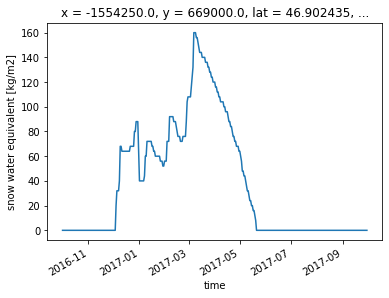

In [16]:
# Plot SWE at this point
my_point_swe.plot()

**Plot a map of SWE on one day, and a marker where our point for the timeseries is:**

(46.5, 47.2)

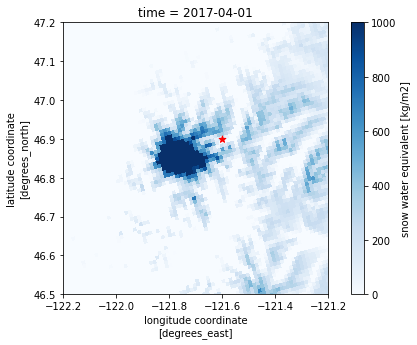

In [17]:
# Plot a map showing where our point is
fig, ax = plt.subplots(figsize=(8,5))

# Plot a map of SWE for April 1st 2017
washington.swe.sel(time='4-1-2017').plot(x='lon', y='lat', cmap='Blues', ax=ax)

# Plot our point
my_point_lon_lat.plot(ax=ax, color='r', marker='*', markersize=50)

# set axes limits
ax.set_xlim([-122.2,-121.2])
ax.set_ylim([46.5,47.2])




---